*   Trennen von ED und ERGO
*   Cluster



In [11]:
%matplotlib inline

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from google.colab import drive

class GC:
    PROJECT_ROOT_DIR = '/content/drive/MyDrive/workspaces/GEAR'
    DATA_DIR = os.path.join(PROJECT_ROOT_DIR, 'data')
    OUTPUT_DIR = os.path.join(PROJECT_ROOT_DIR, 'output')
    TB_LOG_DIR= os.path.join(OUTPUT_DIR, 'tb-logs')
    SRC_DIR = os.path.join(PROJECT_ROOT_DIR, 'src')

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data = pd.ExcelFile(os.path.join(GC.DATA_DIR, 'GEAR_Export_20220106_093424.xlsx'))

df_application = data.parse('Application')[['name']]
df_application.rename(columns={'name':'NAME'}, inplace=True)
df_application.dropna(inplace=True)
df_application.set_index('NAME', inplace=True)
df_application.drop('Name', inplace=True)
df_application['NR'] = np.arange(len(df_application)) + 1
df_application

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,NR
NAME,
OpenDS,1
Active Directory DAS Seguros,2
Active Directory Flexitel,3
Data Warehouse - Informationstechnologie,4
Infolog Tax Suite,5
...,...
INI net (extern),648
UDH Commercial P&C,649
ZKK Beitrag und Rechnung,650


In [3]:
df_interface_provider = data.parse('applicationInterfaceProviderRe')
df_interface_provider.drop(['id', 'type', 'RELATED_FACT_SHEET_TYPE', 'RELATED_FACT_SHEET_TYPE.1', 'status', 'activeFrom', 'activeUntil', 'naFields', 'description'], axis=1, inplace=True)
df_interface_provider.rename(columns = {'RELATED_FACT_SHEET':'PROVIDER_APPLICATION', 'RELATED_FACT_SHEET.1':'INTERFACE'}, inplace = True)
df_interface_provider.dropna(inplace = True)
df_interface_provider.set_index('PROVIDER_APPLICATION', inplace = True)
df_interface_provider.drop('From', inplace = True)

df_interface_provider = df_interface_provider.join(df_application)
df_interface_provider.reset_index(drop=False, inplace=True)
df_interface_provider.rename(columns={'NR':'PROVIDER_NR', 'index':'PROVIDER_APPLICATION'}, inplace=True)
df_interface_provider = df_interface_provider[['INTERFACE', 'PROVIDER_NR', 'PROVIDER_APPLICATION']]
df_interface_provider.set_index('INTERFACE', inplace=True)

df_interface_provider

,PROVIDER_NR,PROVIDER_APPLICATION
INTERFACE,,
AD-DB | Allgemeine Vertragsdaten,11,AD-DB
AD-DB | ZKK Konto,11,AD-DB
AD-DB | Zulagensystem (AZUR),11,AD-DB
AD-DB | iLiFE (Life-Factory),11,AD-DB
AD-DB | Komposit Leistungsbearbeitung (SaViR),11,AD-DB
...,...,...
zentrale Geldeingangsverarbeitung CCM inklusive Geldsuche | ZKK-Partnerinkasso,301,zentrale Geldeingangsverarbeitung CCM inklusiv...
zentrale Geldeingangsverarbeitung CCM inklusive Geldsuche | Leben Verwaltung Antrag/Vertrag,301,zentrale Geldeingangsverarbeitung CCM inklusiv...
zentrale Geldeingangsverarbeitung CCM inklusive Geldsuche | Life Classic Integration,301,zentrale Geldeingangsverarbeitung CCM inklusiv...


In [4]:
df_interface_consumer = data.parse('applicationInterfaceConsumerRe')
df_interface_consumer.drop(['id', 'type', 'RELATED_FACT_SHEET_TYPE', 'RELATED_FACT_SHEET_TYPE.1', 'status', 'activeFrom', 'activeUntil', 'naFields', 'description'], axis=1, inplace=True)
df_interface_consumer.rename(columns = {'RELATED_FACT_SHEET':'CONSUMER_APPLICATION', 'RELATED_FACT_SHEET.1':'INTERFACE'}, inplace = True)
df_interface_consumer.dropna(inplace = True)
df_interface_consumer.set_index('CONSUMER_APPLICATION', inplace = True)
df_interface_consumer.drop('From', inplace=True)

df_interface_consumer = df_interface_consumer.join(df_application)
df_interface_consumer.reset_index(drop=False, inplace=True)
df_interface_consumer.rename(columns={'NR':'CONSUMER_NR', 'index':'CONSUMER_APPLICATION'}, inplace=True)
df_interface_consumer = df_interface_consumer[['INTERFACE', 'CONSUMER_NR', 'CONSUMER_APPLICATION']]
df_interface_consumer.set_index('INTERFACE', inplace=True)

df_interface_consumer

,CONSUMER_NR,CONSUMER_APPLICATION
INTERFACE,,
EASY - ERGO Aussendienst System | AD-DB,11,AD-DB
ZKK Geldverrechnung | AD-DB,11,AD-DB
ZKK Konto | AD-DB,11,AD-DB
ZKK Abrechnungsvereinbarungen | AD-DB,11,AD-DB
DiOrg Aufbauorganisation | AD-DB,11,AD-DB
...,...,...
ZKK-Leistungskontokorrent | zentrale Geldeingangsverarbeitung CCM inklusive Geldsuche,301,zentrale Geldeingangsverarbeitung CCM inklusiv...
ZKK Geldverrechnung | zentrale Geldeingangsverarbeitung CCM inklusive Geldsuche,301,zentrale Geldeingangsverarbeitung CCM inklusiv...
EMS ERGO Mobility Solutions | zentrale Geldeingangsverarbeitung CCM inklusive Geldsuche,301,zentrale Geldeingangsverarbeitung CCM inklusiv...


In [5]:
df_edges = df_interface_provider.join(df_interface_consumer)
df_edges.reset_index(drop=False, inplace=True)
df_edges.dropna(inplace=True)
df_edges['CONSUMER_NR'] = df_edges['CONSUMER_NR'].astype(int)
df_edges

,INTERFACE,PROVIDER_NR,PROVIDER_APPLICATION,CONSUMER_NR,CONSUMER_APPLICATION
0,AD-DB | Allgemeine Vertragsdaten,11,AD-DB,387,Allgemeine Vertragsdaten
1,AD-DB | ZKK Konto,11,AD-DB,177,ZKK Konto
2,AD-DB | Zulagensystem (AZUR),11,AD-DB,500,Zulagensystem (AZUR)
3,AD-DB | iLiFE (Life-Factory),11,AD-DB,644,iLiFE (Life-Factory)
4,AD-DB | Komposit Leistungsbearbeitung (SaViR),11,AD-DB,502,Komposit Leistungsbearbeitung (SaViR)
...,...,...,...,...,...
3090,zentrale Geldeingangsverarbeitung CCM inklusiv...,301,zentrale Geldeingangsverarbeitung CCM inklusiv...,470,ZKK-Partnerinkasso
3091,zentrale Geldeingangsverarbeitung CCM inklusiv...,301,zentrale Geldeingangsverarbeitung CCM inklusiv...,19,Leben Verwaltung Antrag/Vertrag
3092,zentrale Geldeingangsverarbeitung CCM inklusiv...,301,zentrale Geldeingangsverarbeitung CCM inklusiv...,265,Life Classic Integration
3093,zentrale Geldeingangsverarbeitung CCM inklusiv...,301,zentrale Geldeingangsverarbeitung CCM inklusiv...,131,ZKK-Leistungskontokorrent


In [6]:
df_nodes = df_application.reset_index(drop=False, inplace=False)
df_nodes = df_nodes[['NR', 'NAME']]
df_nodes

,NR,NAME
0,1,OpenDS
1,2,Active Directory DAS Seguros
2,3,Active Directory Flexitel
3,4,Data Warehouse - Informationstechnologie
4,5,Infolog Tax Suite
...,...,...
647,648,INI net (extern)
648,649,UDH Commercial P&C
649,650,ZKK Beitrag und Rechnung
650,651,Gebäudewertermittlung SGWE2012


In [7]:
graph = nx.DiGraph()

for c1, c2 in df_nodes.values:
    graph.add_node(c1, name=c2)

for c1, c2, c3, c4, c5 in df_edges.values:
    graph.add_edge(c2, c4, name=c1)

in_degrees = sorted(graph.in_degree(), key = lambda x: x[1], reverse=True)
in_degree_values = [x[1] for x in list(in_degrees)]
in_degree_counts = {x:in_degree_values.count(x) for x in in_degree_values}

print(graph.number_of_nodes(), graph.number_of_edges())
print(in_degrees[:10])
print(in_degree_values[:10])
print(in_degree_counts)

652 3085
[(19, 58), (426, 55), (463, 51), (481, 48), (183, 47), (433, 47), (178, 45), (644, 45), (156, 44), (281, 44)]
[58, 55, 51, 48, 47, 47, 45, 45, 44, 44]
{58: 1, 55: 1, 51: 1, 48: 1, 47: 2, 45: 2, 44: 2, 41: 1, 40: 1, 38: 2, 37: 1, 34: 3, 33: 1, 31: 2, 29: 1, 28: 8, 27: 1, 26: 2, 25: 4, 24: 1, 23: 4, 22: 5, 21: 3, 20: 1, 19: 6, 18: 7, 17: 5, 16: 5, 15: 4, 14: 8, 13: 4, 12: 1, 11: 8, 10: 10, 9: 9, 8: 9, 7: 7, 6: 11, 5: 11, 4: 22, 3: 27, 2: 42, 1: 64, 0: 341}


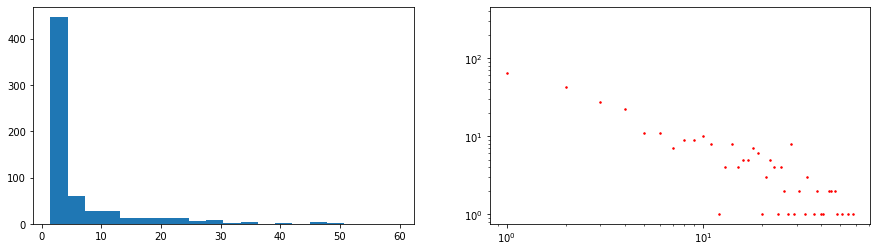

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.hist(in_degree_values, bins=20, align='right', log=False)
ax2.plot(list(in_degree_counts.keys()), list(in_degree_counts.values()), 'r.', markersize=3)
ax2.semilogx()
ax2.semilogy()
plt.show()

In [11]:
sorted(nx.eigenvector_centrality(graph).items(), key=lambda x : x[1], reverse=True)[:10]

[(19, 0.20726794744167967),
 (426, 0.19046464982512962),
 (481, 0.18771879830279717),
 (463, 0.1772344884721616),
 (183, 0.17497571688328473),
 (178, 0.17292901353627724),
 (281, 0.17143437113572016),
 (433, 0.16381169621817168),
 (430, 0.1637439230819195),
 (644, 0.15171234834014893)]

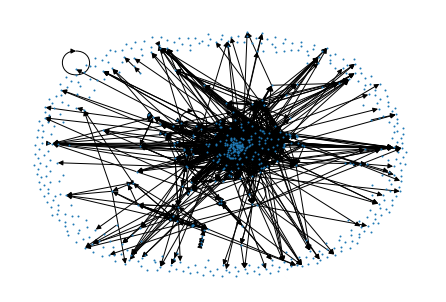

In [12]:
nx.draw(graph, node_size=1)

In [13]:
list(nx.selfloop_edges(graph))

[(111, 111), (222, 222), (369, 369), (573, 573)]

In [14]:
from networkx.algorithms.community import greedy_modularity_communities
c = greedy_modularity_communities(graph)
sorted(c[0])
c

[frozenset({7,
            11,
            19,
            20,
            22,
            30,
            46,
            48,
            55,
            59,
            61,
            66,
            72,
            110,
            111,
            114,
            117,
            128,
            134,
            137,
            160,
            162,
            165,
            171,
            174,
            177,
            178,
            183,
            201,
            203,
            204,
            206,
            211,
            215,
            217,
            226,
            234,
            242,
            247,
            248,
            252,
            257,
            265,
            267,
            270,
            283,
            285,
            287,
            314,
            325,
            333,
            338,
            339,
            343,
            352,
            355,
            360,
            361,
            365,
           